In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from agents import *

In [57]:
reward_map = [1, 0.5, 2.0, -1.0]
reward_map = np.array(reward_map)

reward_map_for_sr = [0.75, 1.00, 0.50, 0.25]
reward_map_for_sr = np.array(reward_map_for_sr)

In [58]:
def list_to_str(in_list):
    out = ""
    for tmp_v in in_list:
        out = out + str(tmp_v)
    return out

In [59]:
'''
Creating a matrix \overline{M}(s, a', s')
'''
def create_q_func_mat(_M, n_state=16, n_action=4):
    tmp_M = np.copy(_M)
    for i in range(n_state):
        for j in range(n_action):
            tmp_M[i*n_action+j, i] = 0.0
    return tmp_M

def create_initial_mat(_M, n_state=16, n_action=4):
    tmp_M = np.copy(_M)
    for i in range(n_state):
        for j in range(n_action):
            tmp_M[i*n_action+j, i] = 1.0
    return tmp_M

In [60]:
def compute_intrisic_rewards(q_M, n_state=16, n_action=4):
    out_vec = np.zeros(n_state)
    for i in range(n_state):
        tmp_v = 0.0
        for j in range(n_action):
            tmp_v = tmp_v + np.sum(q_M[n_action*i + j])
        out_vec[i] = tmp_v
    return out_vec

In [61]:
def create_q_values(M, n_state=16, n_action=4):
    q_M = create_q_func_mat(M, n_state=n_state, n_action=n_action)
    int_rwds = compute_intrisic_rewards(q_M, n_state=n_state, n_action=n_action)
    q_vals = []
    for i in range(n_state*n_action):
        q_vals.append(np.dot(q_M[i,:], int_rwds))
    q_vals = np.array(q_vals).reshape(n_state, n_action)
    return q_vals

In [62]:
def compute_mean_action_sr(M, obs_id, n_state=4**5, n_action=2):
    out_vec = np.zeros(n_state)
    for i in range(n_action):
        out_vec = out_vec + M[obs_id*n_action+i, :]
    out_vec = out_vec / float(n_action)
    return out_vec

In [63]:
def softmax(a, beta=1.0):
    c = np.max(a)
    exp_a = np.exp(a*beta)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

# N = 2

## SR Empowerment vs Q model

In [9]:
game_history = []
error_history = []
q_error_history = []
memory = []

num_memory = 2
n_games = 1000000

lr = 0.1
gamma = 0.8
q_gamma = 0.95

beta = 1.0

n_state=4**num_memory
n_action=2

M = np.zeros((n_state*n_action, n_state))
M = create_initial_mat(M, n_state=n_state, n_action=n_action)

a2_Qs = np.zeros((n_state, n_action))

In [10]:
s1_mat = []
s2_mat = []
cur_obs = None
next_obs = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%100000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        a2_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
        a2_action = np.random.choice([0, 1], p=softmax(a2_Qs[cur_obs,:], beta=beta))
        s1_mat.append(np.mean(q_vals, axis=1).reshape(1, -1))
        s2_mat.append(np.mean(a2_Qs, axis=1).reshape(1, -1))
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        ## SR
        current_act_idx = 2*cur_obs+a1_action
        next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=n_state, n_action=2)
        td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M[current_act_idx, :]
        error_history.append(np.mean(td_err))
        M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
        ## Q
        q_td_err = reward_map[a1_action+(2*a2_action)] + q_gamma*np.max(a2_Qs[next_obs]) - a2_Qs[cur_obs, a2_action]
        q_error_history.append(q_td_err)
        a2_Qs[cur_obs, a2_action] = a2_Qs[cur_obs, a2_action] + lr*q_td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 100000
episode 200000
episode 300000
episode 400000
episode 500000
episode 600000
episode 700000
episode 800000
episode 900000


<Figure size 432x288 with 0 Axes>

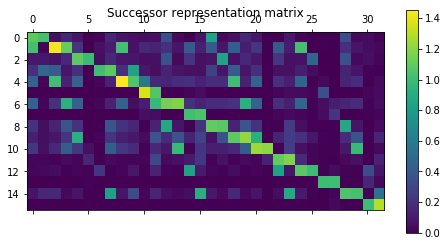

In [11]:
plt.figure()
plt.matshow(M.T)
plt.colorbar()
plt.title("Successor representation matrix")
plt.show()

In [12]:
q_arr = create_q_values(M, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(4), softmax(q_arr[i], beta=beta), s_vals[i])

0000 [9.99895188e-01 1.04811827e-04] 8.376615150341292
0001 [0.33012544 0.66987456] 10.259988607331632
0010 [9.99994738e-01 5.26239611e-06] 7.130806290424967
0011 [9.48449653e-05 9.99905155e-01] 6.478784698067638
0100 [0.97660967 0.02339033] 9.354765949570192
0101 [0.00101228 0.99898772] 8.992225569162462
0110 [0.94015557 0.05984443] 8.820511453095989
0111 [0.09457806 0.90542194] 10.562525711774576
1000 [0.82994968 0.17005032] 8.799393508902384
1001 [0.82982568 0.17017432] 10.843305976046885
1010 [9.99994696e-01 5.30380162e-06] 6.73524818997329
1011 [0.18584639 0.81415361] 9.786087303287049
1100 [9.99972913e-01 2.70868088e-05] 7.918170614123462
1101 [0.57190403 0.42809597] 2.2284034303404217
1110 [0.92542278 0.07457722] 9.353991465773522
1111 [0.04237871 0.95762129] 4.008043819115759


In [13]:
for i in range(len(a2_Qs)):
    print(format(i,'b').zfill(4), softmax(a2_Qs[i], beta=beta), np.mean(a2_Qs[i]))

0000 [7.32198620e-10 9.99999999e-01] 11.56043354636555
0001 [9.99999995e-01 4.80065398e-09] 11.430385108924305
0010 [1.5746608e-10 1.0000000e+00] 11.547388443980525
0011 [9.99999999e-01 1.10585950e-09] 10.169679800939102
0100 [6.0370225e-08 9.9999994e-01] 13.803413183551775
0101 [0.99826729 0.00173271] 4.5025969390128395
0110 [9.99999379e-01 6.21452664e-07] 14.62570633037751
0111 [9.99503966e-01 4.96033781e-04] 3.9589150306596657
1000 [9.99999988e-01 1.19063219e-08] 12.7973775845643
1001 [9.99999706e-01 2.93639555e-07] 14.50205258616144
1010 [1.64077302e-10 1.00000000e+00] 11.519341552697478
1011 [9.99640884e-01 3.59115593e-04] 4.276289107178793
1100 [7.64682668e-04 9.99235317e-01] 6.520951558599142
1101 [0.27378566 0.72621434] 0.5404529894984719
1110 [9.99999671e-01 3.29151622e-07] 14.18523546517636
1111 [0.91316596 0.08683404] 1.5900866889962186


<Figure size 720x720 with 0 Axes>

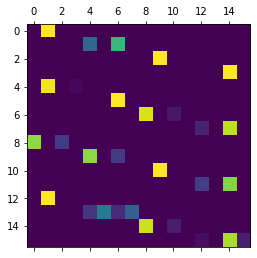

In [14]:
tran_mat = []
for i in range(len(q_arr)):
    tran_vec = np.zeros((1, len(q_arr)))
    prev_state = format(i,'b').zfill(4)[2:]
    for j in [0, 1]:
        for k in [0, 1]:
            next_state = int(prev_state + str(j) + str(k), 2)
            tran_vec[0, next_state] = softmax(a2_Qs[i], beta=beta)[k] * softmax(q_arr[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

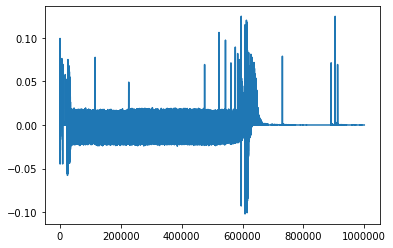

In [15]:
plt.plot(range(len(error_history)), error_history)

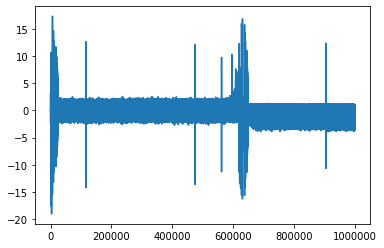

In [16]:
plt.plot(range(len(q_error_history)), q_error_history)

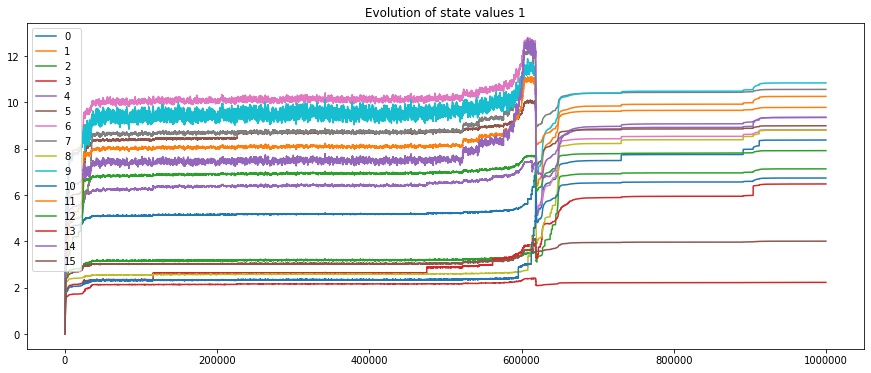

In [17]:
s1_mat = np.concatenate(s1_mat)
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s1_mat)), s1_mat[:, i], label=str(i))
plt.title("Evolution of state values 1")
plt.legend()
plt.show()

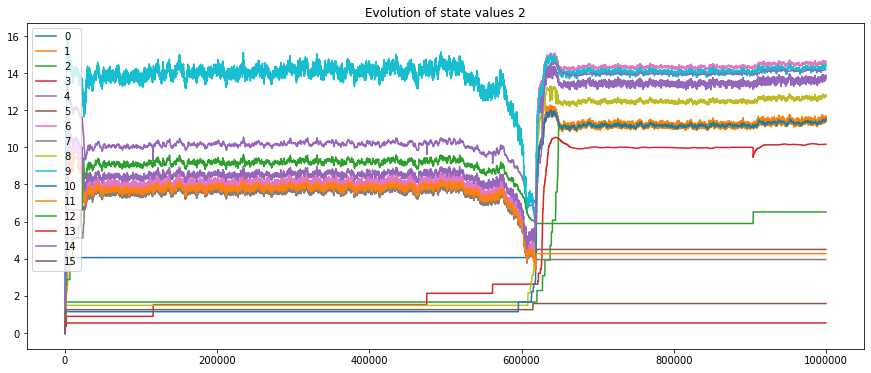

In [18]:
s2_mat = np.concatenate(s2_mat)
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s2_mat)), s2_mat[:, i], label=str(i))
plt.title("Evolution of state values 2")
plt.legend()
plt.show()

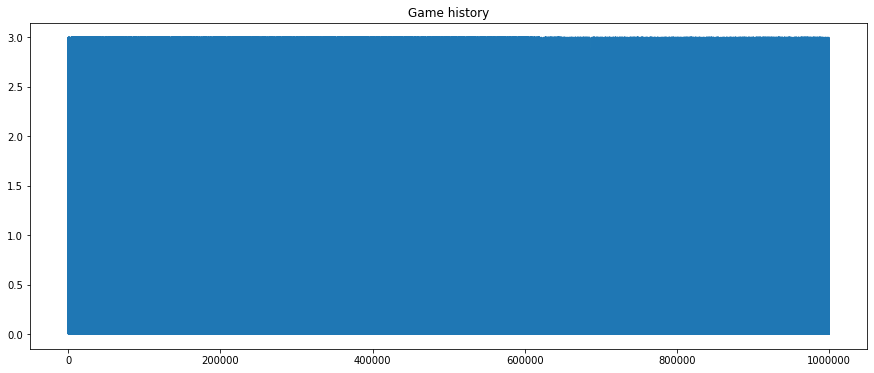

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(game_history)), game_history)
plt.title("Game history")
plt.show()

In [24]:
game_history[-50:]

[1,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 0]

## reward-weighted SR Empowerment vs Q model

In [64]:
game_history = []
error_history = []
q_error_history = []
memory = []

num_memory = 2
n_games = 1000000

lr = 0.1
gamma = 0.8
q_gamma = 0.95

beta = 1.0

n_state=4**num_memory
n_action=2

M = np.zeros((n_state*n_action, n_state))
M = create_initial_mat(M, n_state=n_state, n_action=n_action)

a2_Qs = np.zeros((n_state, n_action))

In [65]:
s1_mat = []
s2_mat = []
cur_obs = None
next_obs = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%100000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        a2_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
        a2_action = np.random.choice([0, 1], p=softmax(a2_Qs[cur_obs,:], beta=beta))
        s1_mat.append(np.mean(q_vals, axis=1).reshape(1, -1))
        s2_mat.append(np.mean(a2_Qs, axis=1).reshape(1, -1))
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        ## SR
        current_act_idx = 2*cur_obs+a1_action
        next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=n_state, n_action=2)
        td_err = np.eye(n_state)[cur_obs] + gamma*reward_map_for_sr[a1_action+(2*a2_action)]*next_sr_vec - M[current_act_idx, :]
        error_history.append(np.mean(td_err))
        M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
        ## Q
        q_td_err = reward_map[a1_action+(2*a2_action)] + q_gamma*np.max(a2_Qs[next_obs]) - a2_Qs[cur_obs, a2_action]
        q_error_history.append(q_td_err)
        a2_Qs[cur_obs, a2_action] = a2_Qs[cur_obs, a2_action] + lr*q_td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 100000
episode 200000
episode 300000
episode 400000
episode 500000


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

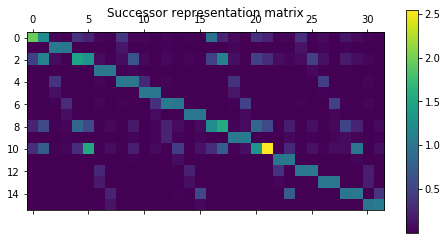

In [66]:
plt.figure()
plt.matshow(M.T)
plt.colorbar()
plt.title("Successor representation matrix")
plt.show()

In [67]:
q_arr = create_q_values(M, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(4), softmax(q_arr[i], beta=beta), s_vals[i])

0000 [0.00734262 0.99265738] 6.133316347730412
0001 [0.60609668 0.39390332] 1.2105960013785435
0010 [0.12608789 0.87391211] 6.359993297873336
0011 [0.47477764 0.52522236] 1.4532738301459505
0100 [0.11210184 0.88789816] 3.1217717264660156
0101 [0.46131331 0.53868669] 1.0570387861665793
0110 [0.48033558 0.51966442] 1.9141498648293964
0111 [0.1813261 0.8186739] 1.5942672325361122
1000 [0.2362516 0.7637484] 6.666657535417942
1001 [0.55128113 0.44871887] 1.6704505959782021
1010 [0.89257627 0.10742373] 5.293326821071795
1011 [0.05781575 0.94218425] 2.600596024946707
1100 [0.26169496 0.73830504] 2.335502695072904
1101 [0.63122229 0.36877771] 1.6239217254540759
1110 [0.26984149 0.73015851] 4.117815275333559
1111 [0.35038241 0.64961759] 1.415833678109578


In [68]:
for i in range(len(a2_Qs)):
    print(format(i,'b').zfill(4), softmax(a2_Qs[i], beta=beta), np.mean(a2_Qs[i]))

0000 [9.99998012e-01 1.98805758e-06] 7.109519004248214
0001 [0.77041471 0.22958529] 1.2752515683412473
0010 [9.99990522e-01 9.47818127e-06] 8.082031139505819
0011 [0.61428997 0.38571003] 1.8599893608598856
0100 [0.91588932 0.08411068] 2.364429805387627
0101 [0.87020592 0.12979408] 0.7482716480999598
0110 [0.48022032 0.51977968] 2.374510990627937
0111 [0.77623679 0.22376321] 1.0914746690945707
1000 [9.99996663e-01 3.33689426e-06] 7.420506204533503
1001 [0.76156112 0.23843888] 2.194019634402511
1010 [9.99988990e-01 1.10096517e-05] 8.32497145178031
1011 [0.94840736 0.05159264] 1.9364631103877805
1100 [0.81561115 0.18438885] 1.8170794352611317
1101 [0.92452675 0.07547325] 1.2158569248500721
1110 [0.9956159 0.0043841] 3.9005931593659433
1111 [0.49386529 0.50613471] 1.7539690528385623


<Figure size 720x720 with 0 Axes>

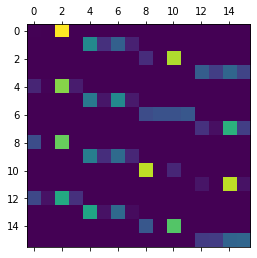

In [69]:
tran_mat = []
for i in range(len(q_arr)):
    tran_vec = np.zeros((1, len(q_arr)))
    prev_state = format(i,'b').zfill(4)[2:]
    for j in [0, 1]:
        for k in [0, 1]:
            next_state = int(prev_state + str(j) + str(k), 2)
            tran_vec[0, next_state] = softmax(a2_Qs[i], beta=beta)[k] * softmax(q_arr[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

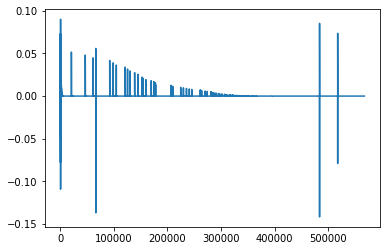

In [70]:
plt.plot(range(len(error_history)), error_history)

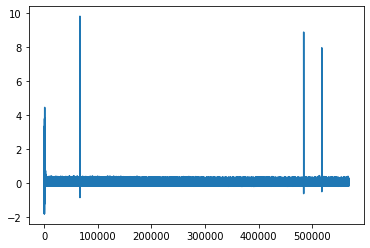

In [71]:
plt.plot(range(len(q_error_history)), q_error_history)

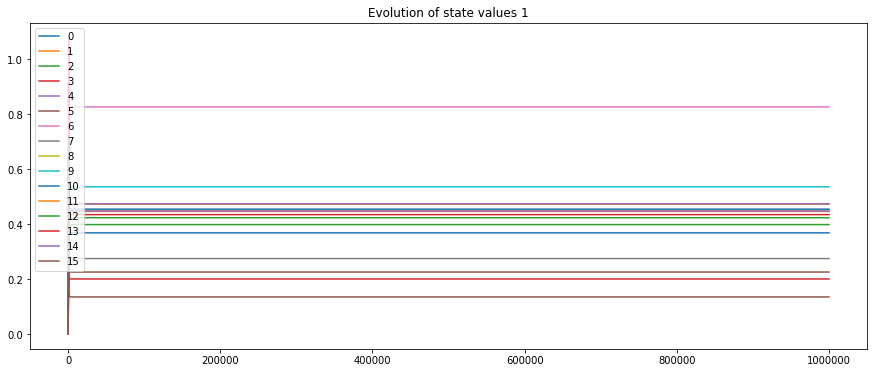

In [54]:
s1_mat = np.concatenate(s1_mat)
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s1_mat)), s1_mat[:, i], label=str(i))
plt.title("Evolution of state values 1")
plt.legend()
plt.show()

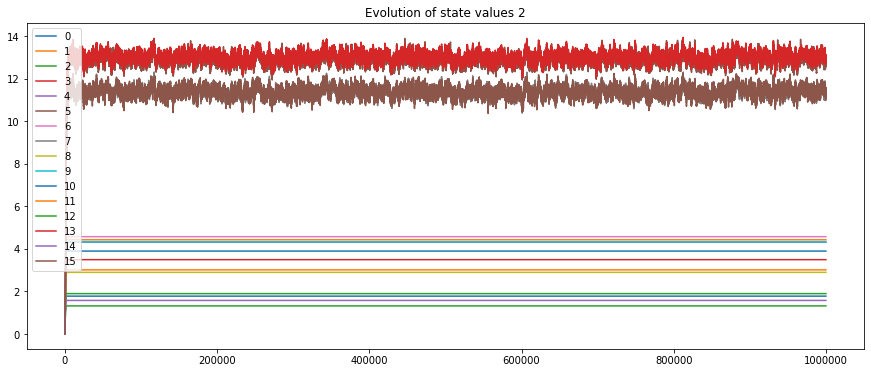

In [55]:
s2_mat = np.concatenate(s2_mat)
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s2_mat)), s2_mat[:, i], label=str(i))
plt.title("Evolution of state values 2")
plt.legend()
plt.show()

In [72]:
game_history[-50:]

[1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0]

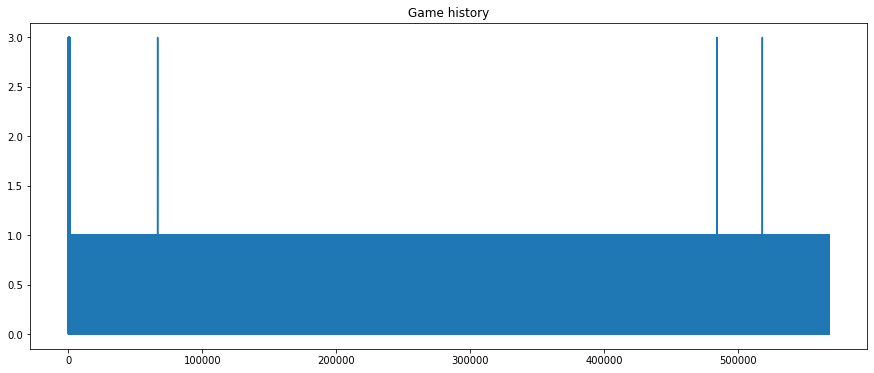

In [73]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(game_history)), game_history)
plt.title("Game history")
plt.show()

# N = 3

## SR Empowerment vs Q model

In [25]:
game_history = []
error_history = []
q_error_history = []
memory = []

num_memory = 3
n_games = 1000000

lr = 0.1
gamma = 0.8
q_gamma = 0.95

beta = 1.0

n_state=4**num_memory
n_action=2

M = np.zeros((n_state*n_action, n_state))
M = create_initial_mat(M, n_state=n_state, n_action=n_action)

a2_Qs = np.zeros((n_state, n_action))

In [26]:
s1_mat = []
s2_mat = []
cur_obs = None
next_obs = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%100000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        a2_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
        a2_action = np.random.choice([0, 1], p=softmax(a2_Qs[cur_obs,:], beta=beta))
        s1_mat.append(np.mean(q_vals, axis=1).reshape(1, -1))
        s2_mat.append(np.mean(a2_Qs, axis=1).reshape(1, -1))
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        ## SR
        current_act_idx = 2*cur_obs+a1_action
        next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=n_state, n_action=2)
        td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M[current_act_idx, :]
        error_history.append(np.mean(td_err))
        M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
        ## Q
        q_td_err = reward_map[a1_action+(2*a2_action)] + q_gamma*np.max(a2_Qs[next_obs]) - a2_Qs[cur_obs, a2_action]
        q_error_history.append(q_td_err)
        a2_Qs[cur_obs, a2_action] = a2_Qs[cur_obs, a2_action] + lr*q_td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 100000
episode 200000
episode 300000
episode 400000
episode 500000
episode 600000
episode 700000
episode 800000
episode 900000


<Figure size 432x288 with 0 Axes>

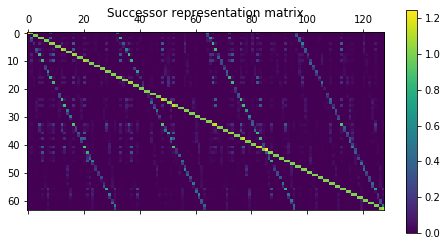

In [27]:
plt.figure()
plt.matshow(M.T)
plt.colorbar()
plt.title("Successor representation matrix")
plt.show()

In [28]:
q_arr = create_q_values(M, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(6), softmax(q_arr[i], beta=beta), s_vals[i])

000000 [0.00428067 0.99571933] 2.887133518863958
000001 [0.12551575 0.87448425] 2.0265146882014315
000010 [0.05719394 0.94280606] 9.994547106326987
000011 [0.01361678 0.98638322] 2.862938690688865
000100 [0.01914264 0.98085736] 9.75544133972802
000101 [0.1484853 0.8515147] 1.0301599697060704
000110 [0.64727886 0.35272114] 8.440799743313722
000111 [0.5508477 0.4491523] 3.0760420698610957
001000 [9.99987894e-01 1.21056844e-05] 7.135536802196052
001001 [0.22973713 0.77026287] 3.122798677249003
001010 [0.99881779 0.00118221] 9.303632649020912
001011 [0.03325942 0.96674058] 3.146113145947999
001100 [0.56178354 0.43821646] 1.127440213770979
001101 [0.35280334 0.64719666] 1.1807479566320334
001110 [0.98111733 0.01888267] 5.440844527780457
001111 [0.16383033 0.83616967] 2.6907474854267632
010000 [1.95832479e-05 9.99980417e-01] 6.521535508679952
010001 [0.05279414 0.94720586] 4.510751853101039
010010 [0.05797286 0.94202714] 9.807415941117736
010011 [0.00276972 0.99723028] 3.293077717377519
0101

In [29]:
for i in range(len(a2_Qs)):
    print(format(i,'b').zfill(6), softmax(a2_Qs[i], beta=beta), np.mean(a2_Qs[i]))

000000 [0.98337552 0.01662448] 1.6888088215416228
000001 [0.65619395 0.34380605] 0.3223759976468266
000010 [9.99999807e-01 1.93073744e-07] 8.069214851082032
000011 [0.87939036 0.12060964] 1.3499473025515254
000100 [9.99996431e-01 3.56886928e-06] 8.713944812450727
000101 [0.63332413 0.36667587] 0.1470786968366333
000110 [9.99990421e-01 9.57898111e-06] 10.29514383845574
000111 [0.75683965 0.24316035] 1.4963415788641057
001000 [2.07918978e-07 9.99999792e-01] 8.79865135624885
001001 [0.63958591 0.36041409] 0.6598871537526786
001010 [1.00939217e-07 9.99999899e-01] 8.447895713394637
001011 [0.6711587 0.3288413] 1.3536616590093908
001100 [0.48141803 0.51858197] 0.3286394984678883
001101 [0.66464832 0.33535168] 0.1723619616590379
001110 [0.9958594 0.0041406] 3.9774290372084002
001111 [0.74612229 0.25387771] 1.3950124761462264
010000 [9.99999730e-01 2.70470175e-07] 7.443560840538486
010001 [0.98972577 0.01027423] 2.375410059489968
010010 [9.99999700e-01 3.00372893e-07] 8.194737901533198
010011 

<Figure size 720x720 with 0 Axes>

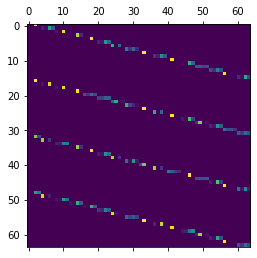

In [30]:
tran_mat = []
for i in range(len(q_arr)):
    tran_vec = np.zeros((1, len(q_arr)))
    prev_state = format(i,'b').zfill(6)[2:]
    for j in [0, 1]:
        for k in [0, 1]:
            next_state = int(prev_state + str(j) + str(k), 2)
            tran_vec[0, next_state] = softmax(a2_Qs[i], beta=beta)[k] * softmax(q_arr[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

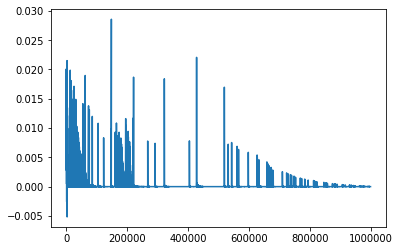

In [31]:
plt.plot(range(len(error_history)), error_history)

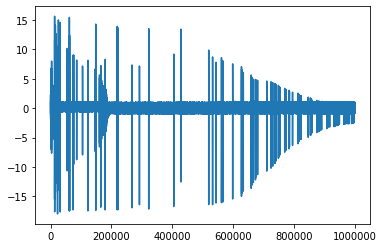

In [32]:
plt.plot(range(len(q_error_history)), q_error_history)

In [33]:
game_history[-1000:]

[2,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 0,


In [16]:
all_c_agent = All_C_Agent()